In [1]:
import yfinance as yf
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
#ignore convergence warnings
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

In [3]:
# Download stock data for Apple (AAPL)
ticker = 'AAPL'
data = yf.download(ticker, start='2018-01-01', end='2023-01-01')

# Preview the data
print(data.head())

[*********************100%***********************]  1 of 1 completed

                 Open       High        Low      Close  Adj Close     Volume
Date                                                                        
2018-01-02  42.540001  43.075001  42.314999  43.064999  40.568928  102223600
2018-01-03  43.132500  43.637501  42.990002  43.057499  40.561863  118071600
2018-01-04  43.134998  43.367500  43.020000  43.257500  40.750271   89738400
2018-01-05  43.360001  43.842499  43.262501  43.750000  41.214230   94640000
2018-01-08  43.587502  43.902500  43.482498  43.587502  41.061150   82271200


In [97]:
# Use the 'Close' prices for the model
#note close prices don't include the weekend
close_prices = data['Close']
close_prices.index = pd.to_datetime(data.index)

In [98]:
# Split the data into training and testing sets
train = close_prices[:int(0.8 * len(close_prices))]
test = close_prices[int(0.8 * len(close_prices)):]

In [100]:
# Set frequency for the training index
train.index = pd.date_range(start=train.index[0], periods=len(train), freq='B')

In [101]:
ets_model = sm.tsa.ExponentialSmoothing(
    train, 
    trend='add', 
    seasonal='add', 
    seasonal_periods=365,
    initialization_method='estimated'  # or 'heuristic'
).fit(optimized=True)

In [102]:
# Forecast the test period
forecast_steps = len(test)
forecast = ets_model.forecast(steps=forecast_steps)
forecast_index = pd.date_range(start=train.index[-1] + pd.Timedelta(days=1), periods=forecast_steps, freq='B')
forecast = pd.Series(forecast, index=forecast_index)

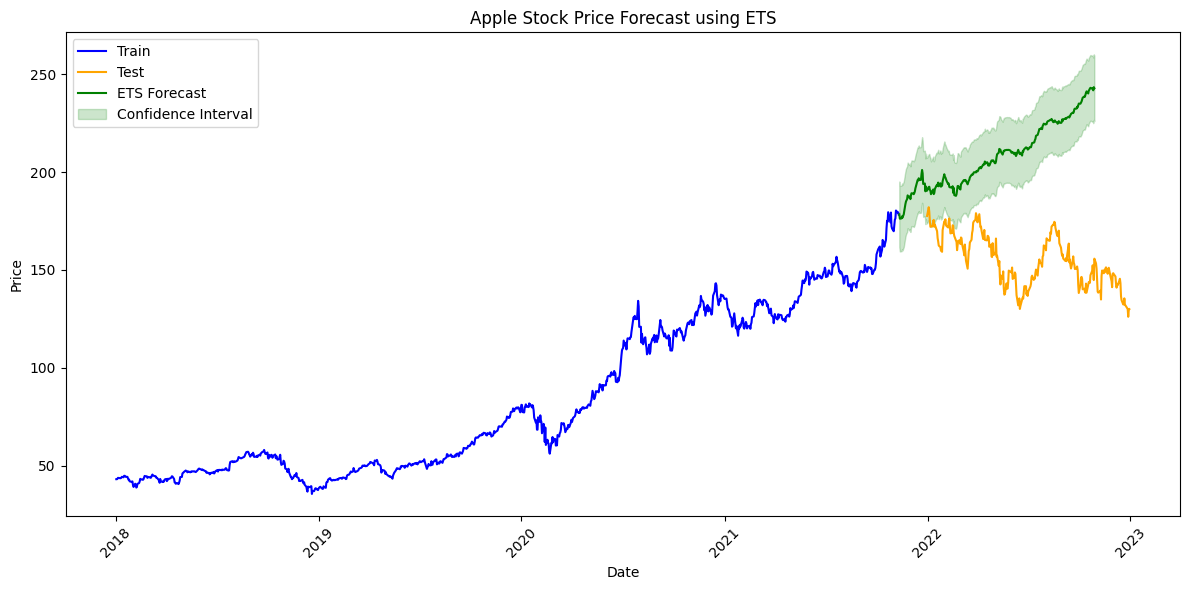

In [103]:
# Plot the actual vs. forecasted values
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Train', color='blue')
plt.plot(test.index, test, label='Test', color='orange')
plt.plot(forecast.index, forecast, label='ETS Forecast', color='green')
plt.fill_between(forecast.index, forecast - forecast.std(), forecast + forecast.std(), color='green', alpha=0.2, label='Confidence Interval')
plt.legend(loc='best')
plt.title('Apple Stock Price Forecast using ETS')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [104]:
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test, forecast))
print(f'Root Mean Squared Error: {rmse}')

# Calculate MAE
mae = mean_absolute_error(test, forecast)
print(f'Mean Absolute Error: {mae}')

# Calculate MAPE
mape = np.mean(np.abs((test - forecast) / test)) * 100
print(f'Mean Absolute Percentage Error: {mape}%')

Root Mean Squared Error: 60.137298565507734
Mean Absolute Error: 53.68340520709382
Mean Absolute Percentage Error: 35.811105785587785%
